In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

%matplotlib inline
from IPython import display


import functions.parse_data as parse
import functions.handy_functions as hf
import torch.nn as nn
import torch


from multivariate_quantile_regression.network_model import QuantileNetwork

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from tqdm import tqdm

import os

import netCDF4 as nc
import glob

from functions.plot_metrics import plot_metrics
from functions.plot_metrics_one import plot_metrics_one
from functions import calc_metrics

/tmp/ipykernel_195864/2101664275.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-03-22 08:07:22.223170: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-22 08:07:22.257897: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-22 08:0

In [2]:
data_water=parse.parse('cloudrm2_water.dat')
data_clear=parse.parse('cloudrm2_clear.dat')
data_ice=parse.parse('cloudrm2_ice.dat')
data_mixed=parse.parse('cloudrm2_mixed.dat')

#Concatinate all datasets
#data_all=pd.concat([data_water,data_clear,data_ice,data_mixed,
#                    data_black_water,data_black_clear,data_black_ice,data_black_mixed])
data_all=pd.concat([data_water,data_clear,data_ice,data_mixed])


data_all=hf.dumb_down_surface(data_all)
data_all=data_all.drop(columns=['Surface_Desc','Cloud_B01','Clear_B01'])
data_all=data_all.reset_index()
data_all=data_all.drop(columns=('index'))

df=data_all.copy()

X_labels= ['Cloud_B02','Cloud_B03','Cloud_B04','Cloud_B05','Cloud_B06',
           'Cloud_B07','Cloud_B08','Cloud_B09','Cloud_B10','Cloud_B11','Cloud_B12','Cloud_B13']
#Leave out 'GOT', 'Water_Vapor'
#Band 1 no go.
y_labels=['Clear_B02','Clear_B03','Clear_B04','Clear_B05',
              'Clear_B06','Clear_B07','Clear_B08', 'Clear_B09',
              'Clear_B10','Clear_B11','Clear_B12','Clear_B13']
#clear_labels=['Clear_B02','Clear_B03','Clear_B04','Clear_B05',
#              'Clear_B06','Clear_B07','Clear_B08', 'Clear_B09',
#              'Clear_B10','Clear_B11','Clear_B12','Clear_B13']

#y_labels= ['OCloud_B02','OCloud_B03','OCloud_B04','OCloud_B05','OCloud_B06',
#           'OCloud_B07','OCloud_B08','OCloud_B09','OCloud_B10','OCloud_B11','OCloud_B12','OCloud_B13']

#df[y_labels]=df[X_labels].to_numpy()-df[clear_labels].to_numpy()

In [4]:
data_all.Surface_Desc_Dumb.value_counts()

Surface_Desc_Dumb
vegetation                     141346
rock                            21008
nonphotosyntheticvegetation     15594
water                           11519
soil                            10533
Name: count, dtype: int64

In [12]:
df_veg=df[df['Surface_Desc_Dumb']=='vegetation']
df_veg_clear=df_veg[df_veg['COT']==0]
df_veg_3_6=df_veg[(df_veg['COT']>0)&(df_veg['COT']<=3.6)]

In [26]:
image=np.zeros((256,256,12))


sample_count=0
for i in range(int(len(df_veg_clear)/256)):
    for j in range(int(len(df_veg_clear)/256)):
        image[i,j,:]=df_veg_clear.iloc[sample_count][X_labels].to_numpy()
        sample_count+=1


In [28]:
sample_count

18769

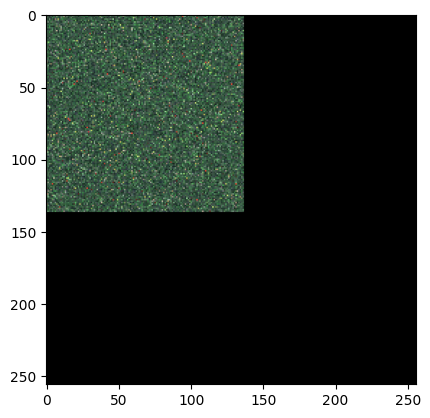

In [27]:
plt.imshow(image[:,:,[2,1,0]])

In [30]:
import random
samp_size=256*256
sample_indc=np.array(random.sample(range(len(df['Cloud_B02'])), samp_size))
df_im=df.iloc[sample_indc]

In [32]:
df_im_cloud=df_im[X_labels]
df_im_clear=df_im[y_labels]

In [38]:
im=np.reshape(df_im_cloud.to_numpy(),(256,256,12))
im_truth=np.reshape(df_im_clear.to_numpy(),(256,256,12))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


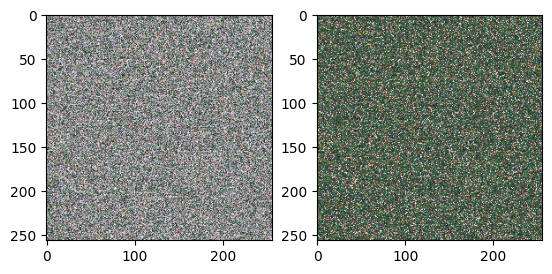

In [40]:
fig,axs=plt.subplots(ncols=2,nrows=1)
axs[0].imshow(im[:,:,[2,1,0]])
axs[1].imshow(im_truth[:,:,[2,1,0]])